# Task 1: Rating Prediction via Prompting

## Overview
This notebook implements a comprehensive evaluation of a custom-designed hybrid method incorporating three distinct prompting styles for classifying Yelp reviews into 1-5 star ratings using the Ollama model "gemma2:2b". The analysis includes accuracy assessment, JSON validity rates, and reliability metrics on a sampled dataset of 200 reviews.

## Dataset Preparation
- **Source**: Yelp Reviews dataset from Kaggle (https://www.kaggle.com/datasets/omkarsabnis/yelp-reviews-dataset)
- **Sampling**: First 200 reviews selected for consistency and efficiency
- **Preprocessing**: Filtered to include only reviews with valid text and star ratings

## Custom Hybrid Prompting Method
I designed a hybrid method that combines three complementary prompting styles to optimize model performance and adaptability:

### 1. Exemplar-Based Prompting
This style leverages concrete examples to anchor the model's understanding of sentiment-to-rating mapping. By providing prototypical reviews for 1, 3, and 5 stars, it guides the model toward more calibrated predictions.

### 2. Analytical Step-by-Step Prompting
This style structures the reasoning process by breaking down sentiment analysis into explicit steps: identifying positive/negative aspects, assessing overall sentiment, and determining the star rating. It promotes transparency and consistency in the model's decision-making.

### 3. Direct & Simple Prompting
This style focuses on clarity and brevity, instructing the model to classify directly with minimal guidance. This tests the model's inherent understanding without additional scaffolding.

## Evaluation Methodology
- **Metrics**:
  - **Accuracy**: Percentage of correct predictions among valid responses
  - **JSON Validity Rate**: Proportion of responses that parse correctly into the required format
  - **Reliability**: Consistency in predictions and error distribution
- **Dataset**: 200 reviews processed per strategy
- **Output Format**: Structured JSON with `predicted_stars` (1-5) and `explanation`

## Results and Discussion
The comparison reveals trade-offs between the hybrid styles:
- Exemplar-Based often provides higher accuracy by offering clear benchmarks but may reduce validity if examples bias the model.
- Analytical Step-by-Step enhances explainability and consistency, though it can increase processing time.
- Direct & Simple is efficient and straightforward, yielding reliable results with minimal overhead.

Detailed results, including error analysis and visualizations, are presented below.

In [6]:
# Import required libraries
import pandas as pd
import json
import re
import ollama
from datetime import datetime

## Configuration and Setup
- Model: Ollama "gemma2:2b" for local inference
- Reviews Processed: 200 per strategy
- Libraries: pandas, json, re, ollama, datetime, matplotlib, numpy

In [7]:
# Configuration
MODEL_NAME = "gemma2:2b"
NUM_REVIEWS = 200  # Process first 200 reviews

print(f"Using Ollama locally with {MODEL_NAME}")
print(f"Will process {NUM_REVIEWS} reviews with 3 different prompting strategies")

Using Ollama locally with gemma2:2b
Will process 200 reviews with 3 different prompting strategies


## Dataset Loading and Cleaning
- Loaded CSV file from `C:\fynd-task\yelp.csv`
- Selected columns: `review_id`, `text`, `stars`
- Removed null values and empty text entries
- Sampled first 200 reviews for evaluation
- Star distribution displayed for reference

In [8]:
# Load Yelp dataset
df = pd.read_csv(r"C:\fynd-task\yelp.csv")

# Clean the data
df = df[["review_id", "text", "stars"]].dropna()
df = df[df["text"].str.strip() != ""]

# Select first 200 reviews (not random - consistent across all prompts)
df_subset = df.head(NUM_REVIEWS).reset_index(drop=True)

print(f"Dataset loaded: {len(df_subset)} reviews")
print(f"Star distribution:\n{df_subset['stars'].value_counts().sort_index()}")
df_subset.head()

Dataset loaded: 200 reviews
Star distribution:
stars
1    21
2    11
3    28
4    71
5    69
Name: count, dtype: int64


,review_id,text,stars
0,fWKvX83p0-ka4JS3dc6E5A,My wife took me here on my birthday for breakf...,5
1,IjZ33sJrzXqU-0X6U8NwyA,I have no idea why some people give bad review...,5
2,IESLBzqUCLdSzSqm0eCSxQ,love the gyro plate. Rice is so good and I als...,4
3,G-WvGaISbqqaMHlNnByodA,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",5
4,1uJFq2r5QfJG_6ExMRCaGw,General Manager Scott Petello is a good egg!!!...,5


## JSON Parsing Utility
A robust function to extract and validate JSON responses from the model, including fallback parsing for invalid formats. Ensures reliable extraction of `predicted_stars` and `explanation`.

In [9]:
def parse_json_response(text):
    """
    Robustly parse JSON from model response.
    Handles multiple formats and fallback parsing.
    
    Returns: (predicted_stars, explanation) or (None, error_message)
    """
    if not text:
        return None, "Empty response"
    
    text = text.strip()
    
    # Try to extract JSON object from response
    json_match = re.search(r'\{.*?"predicted_stars".*?\}', text, re.DOTALL)
    
    if json_match:
        try:
            data = json.loads(json_match.group())
            predicted = data.get("predicted_stars")
            explanation = data.get("explanation", "")
            
            # Validate star rating
            if predicted and 1 <= int(predicted) <= 5:
                return int(predicted), explanation
        except (json.JSONDecodeError, ValueError, TypeError):
            pass
    
    # Fallback: Try to extract star rating from text
    star_match = re.search(r'(?:predicted_stars|rating|stars).*?(\d)', text, re.IGNORECASE)
    if star_match:
        predicted = int(star_match.group(1))
        if 1 <= predicted <= 5:
            return predicted, "Fallback parsing - no explanation"
    
    return None, text[:100]  # Return first 100 chars as error message

# # 3 Hybrid Prompting Strategies

 We'll test three different prompting approaches:
 1. **Exemplar-Based**: Uses concrete examples to guide the model
 2. **Analytical Step-by-Step**: Breaks down the analysis process
 3. **Direct & Simple**: Minimalist approach with clear instructions

In [11]:
def prompt_exemplar_based(review_text):
    """
    Strategy 1: Exemplar-Based Prompting
    Provides concrete examples to anchor the model's understanding
    """
    return f"""You are a Yelp review classifier. Predict the star rating (1-5) based on the review text.

EXAMPLES:
- "Terrible food, rude staff, never coming back!" → 1 star
- "Mediocre experience, nothing special" → 3 stars  
- "Amazing food and excellent service!" → 5 stars

REVIEW TO CLASSIFY:
"{review_text}"

Respond ONLY with JSON in this exact format:
{{"predicted_stars": <1-5>, "explanation": "<brief reason>"}}"""

In [12]:
def prompt_analytical_steps(review_text):
    """
    Strategy 2: Analytical Step-by-Step Prompting
    Guides the model through structured reasoning
    """
    return f"""Analyze this Yelp review and predict the star rating (1-5).

REVIEW:
"{review_text}"

ANALYSIS STEPS:
1. Identify positive and negative aspects
2. Assess overall sentiment
3. Determine appropriate star rating (1=worst, 5=best)

Respond ONLY with JSON in this exact format:
{{"predicted_stars": <1-5>, "explanation": "<your analysis>"}}"""

In [13]:
def prompt_direct_simple(review_text):
    """
    Strategy 3: Direct & Simple Prompting
    Minimalist approach with clear constraints
    """
    return f"""Classify this Yelp review with a star rating from 1 to 5.

Review: "{review_text}"

Respond ONLY with JSON:
{{"predicted_stars": <1-5>, "explanation": "<short reason>"}}"""

# Process Reviews with Each Strategy

Each strategy will process all 200 reviews and save results to a file.

In [14]:
def evaluate_prompt_strategy(df, prompt_function, strategy_name):
    """
    Evaluate a single prompting strategy on all reviews.
    
    Args:
        df: DataFrame with reviews
        prompt_function: Function that generates the prompt
        strategy_name: Name for saving results
    
    Returns:
        Dictionary with results and statistics
    """
    print(f"\n{'='*70}")
    print(f"Running Strategy: {strategy_name}")
    print(f"{'='*70}\n")
    
    results = []
    valid_count = 0
    correct_count = 0
    
    for idx, row in df.iterrows():
        review_text = row["text"]
        actual_stars = int(row["stars"])
        
        # Generate prompt and get response from Ollama
        prompt = prompt_function(review_text)
        response = ollama.generate(model=MODEL_NAME, prompt=prompt)
        raw_output = response['response']
        
        # Parse the response
        predicted_stars, explanation = parse_json_response(raw_output)
        
        # Track statistics
        is_valid = predicted_stars is not None
        is_correct = (predicted_stars == actual_stars) if is_valid else False
        
        if is_valid:
            valid_count += 1
        if is_correct:
            correct_count += 1
        
        # Store result
        results.append({
            "review_id": row["review_id"],
            "actual_stars": actual_stars,
            "predicted_stars": predicted_stars,
            "match": is_correct,
            "explanation": explanation,
            "raw_response": raw_output
        })
        
        # Progress update every 10 reviews
        if (idx + 1) % 10 == 0:
            print(f"Progress: {idx + 1}/{len(df)} | Valid: {valid_count} | Correct: {correct_count}")
    
    # Save results to file
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"results_{strategy_name.lower().replace(' ', '_')}_{timestamp}.json"
    
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=2, ensure_ascii=False)
    
    print(f"\n✓ Results saved to: {filename}")
    
    # Calculate statistics
    accuracy = (correct_count / valid_count * 100) if valid_count > 0 else 0
    validity_rate = (valid_count / len(df) * 100)
    
    return {
        "strategy": strategy_name,
        "results": results,
        "valid_responses": valid_count,
        "correct_predictions": correct_count,
        "accuracy": accuracy,
        "validity_rate": validity_rate,
        "output_file": filename
    }

## Execution of Strategies
All three strategies are run sequentially on the dataset, with progress updates and completion confirmation.

In [15]:
# Run all three strategies
strategies = [
    (prompt_exemplar_based, "Exemplar-Based"),
    (prompt_analytical_steps, "Analytical Step-by-Step"),
    (prompt_direct_simple, "Direct & Simple")
]

all_results = []

for prompt_fn, strategy_name in strategies:
    result = evaluate_prompt_strategy(df_subset, prompt_fn, strategy_name)
    all_results.append(result)
    
print(f"\n{'='*70}")
print("ALL STRATEGIES COMPLETED!")
print(f"{'='*70}")


Running Strategy: Exemplar-Based

Progress: 10/200 | Valid: 10 | Correct: 9
Progress: 20/200 | Valid: 20 | Correct: 16
Progress: 30/200 | Valid: 30 | Correct: 24
Progress: 40/200 | Valid: 40 | Correct: 30
Progress: 50/200 | Valid: 50 | Correct: 35
Progress: 60/200 | Valid: 60 | Correct: 41
Progress: 70/200 | Valid: 70 | Correct: 45
Progress: 80/200 | Valid: 80 | Correct: 53
Progress: 90/200 | Valid: 90 | Correct: 60
Progress: 100/200 | Valid: 100 | Correct: 65
Progress: 110/200 | Valid: 110 | Correct: 74
Progress: 120/200 | Valid: 120 | Correct: 76
Progress: 130/200 | Valid: 130 | Correct: 81
Progress: 140/200 | Valid: 140 | Correct: 85
Progress: 150/200 | Valid: 150 | Correct: 91
Progress: 160/200 | Valid: 160 | Correct: 99
Progress: 170/200 | Valid: 170 | Correct: 106
Progress: 180/200 | Valid: 180 | Correct: 115
Progress: 190/200 | Valid: 190 | Correct: 123
Progress: 200/200 | Valid: 200 | Correct: 129

✓ Results saved to: results_exemplar-based_20260107_015330.json

Running Strate

# Summary & Comparison

#Compare the performance of all three prompting strategies.

In [16]:
# Create comparison summary
summary_data = []

for result in all_results:
    # Calculate error distribution
    errors = []
    for item in result["results"]:
        if item["predicted_stars"] is not None:
            error = abs(item["actual_stars"] - item["predicted_stars"])
            errors.append(error)
    
    avg_error = sum(errors) / len(errors) if errors else 0
    
    summary_data.append({
        "Strategy": result["strategy"],
        "Valid Responses": f"{result['valid_responses']}/{NUM_REVIEWS}",
        "Validity Rate": f"{result['validity_rate']:.1f}%",
        "Accuracy": f"{result['accuracy']:.1f}%",
        "Avg Error": f"{avg_error:.2f} stars",
        "Output File": result["output_file"]
    })

# Display comparison table
summary_df = pd.DataFrame(summary_data)
print("\n" + "="*70)
print("PERFORMANCE COMPARISON")
print("="*70 + "\n")
display(summary_df)

# Find best strategy
best_strategy = max(all_results, key=lambda x: x['accuracy'])
print(f"\n🏆 Best Strategy: {best_strategy['strategy']}")
print(f"   Accuracy: {best_strategy['accuracy']:.1f}%")
print(f"   Valid Responses: {best_strategy['valid_responses']}/{NUM_REVIEWS}")


PERFORMANCE COMPARISON



,Strategy,Valid Responses,Validity Rate,Accuracy,Avg Error,Output File
0,Exemplar-Based,200/200,100.0%,64.5%,0.39 stars,results_exemplar-based_20260107_015330.json
1,Analytical Step-by-Step,200/200,100.0%,56.5%,0.47 stars,results_analytical_step-by-step_20260107_01584...
2,Direct & Simple,199/200,99.5%,65.8%,0.38 stars,results_direct_&_simple_20260107_020216.json



🏆 Best Strategy: Direct & Simple
   Accuracy: 65.8%
   Valid Responses: 199/200


# Detailed Error Analysis

Examine prediction errors for insights.

In [17]:
# Analyze errors for each strategy
for result in all_results:
    print(f"\n{'='*70}")
    print(f"{result['strategy']} - Error Distribution")
    print(f"{'='*70}")
    
    error_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
    
    for item in result["results"]:
        if item["predicted_stars"] is not None:
            error = abs(item["actual_stars"] - item["predicted_stars"])
            error_counts[error] += 1
    
    total_valid = sum(error_counts.values())
    
    print(f"Exact matches (0 error):  {error_counts[0]:3d} ({error_counts[0]/total_valid*100:.1f}%)")
    print(f"Off by 1 star:            {error_counts[1]:3d} ({error_counts[1]/total_valid*100:.1f}%)")
    print(f"Off by 2 stars:           {error_counts[2]:3d} ({error_counts[2]/total_valid*100:.1f}%)")
    print(f"Off by 3+ stars:          {error_counts[3] + error_counts[4]:3d} ({(error_counts[3] + error_counts[4])/total_valid*100:.1f}%)")


Exemplar-Based - Error Distribution
Exact matches (0 error):  129 (64.5%)
Off by 1 star:             67 (33.5%)
Off by 2 stars:             3 (1.5%)
Off by 3+ stars:            1 (0.5%)

Analytical Step-by-Step - Error Distribution
Exact matches (0 error):  113 (56.5%)
Off by 1 star:             82 (41.0%)
Off by 2 stars:             4 (2.0%)
Off by 3+ stars:            1 (0.5%)

Direct & Simple - Error Distribution
Exact matches (0 error):  131 (65.8%)
Off by 1 star:             63 (31.7%)
Off by 2 stars:             4 (2.0%)
Off by 3+ stars:            1 (0.5%)


# Sample Outputs from Each Strategy

View example predictions from each prompting approach.

In [20]:
# Save all results for each strategy in JSON format
for result in all_results:
    strategy = result['strategy']
    
    # Prepare clean output with only required fields
    clean_results = []
    for item in result['results']:
        output = {
            "review_id": item['review_id'],
            "actual_stars": item['actual_stars'],
            "predicted_stars": item['predicted_stars'],
            "explanation": item['explanation']
        }
        clean_results.append(output)
    
    # Save to JSON file named after the strategy
    filename = f"{strategy.lower().replace(' ', '_').replace('-', '_')}.json"
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(clean_results, f, indent=2, ensure_ascii=False)
    
    print(f"✓ {strategy}: {filename}")
    print(f"  Total reviews: {len(clean_results)}")
    print(f"  Sample output:")
    print(json.dumps(clean_results[0], indent=2))
    print()

print("\n" + "="*70)
print("All results saved in 3 separate JSON files!")
print("="*70)

✓ Exemplar-Based: exemplar_based.json
  Total reviews: 200
  Sample output:
{
  "review_id": "fWKvX83p0-ka4JS3dc6E5A",
  "actual_stars": 5,
  "predicted_stars": 5,
  "explanation": "The review expresses strong positive emotions about the food, service, and atmosphere. Multiple details are provided to highlight their excellence."
}

✓ Analytical Step-by-Step: analytical_step_by_step.json
  Total reviews: 200
  Sample output:
{
  "review_id": "fWKvX83p0-ka4JS3dc6E5A",
  "actual_stars": 5,
  "predicted_stars": 5,
  "explanation": "The review overwhelmingly expresses positive sentiments about the restaurant.  They mention a pleasant outdoor setting, excellent service, quick food delivery, and delicious dishes. The reviewer specifically praises the Bloody Mary, describing it as 'phenomenal' and one of the best they've had. They also highlight the tasty white truffle scrambled eggs, the amazing bread, and express a clear desire to return. This level of detail and enthusiasm strongly suggests

# Visual Comparison of Strategies

Compare performance metrics across all three prompting strategies.


✓ Visualization saved to: strategy_comparison.png


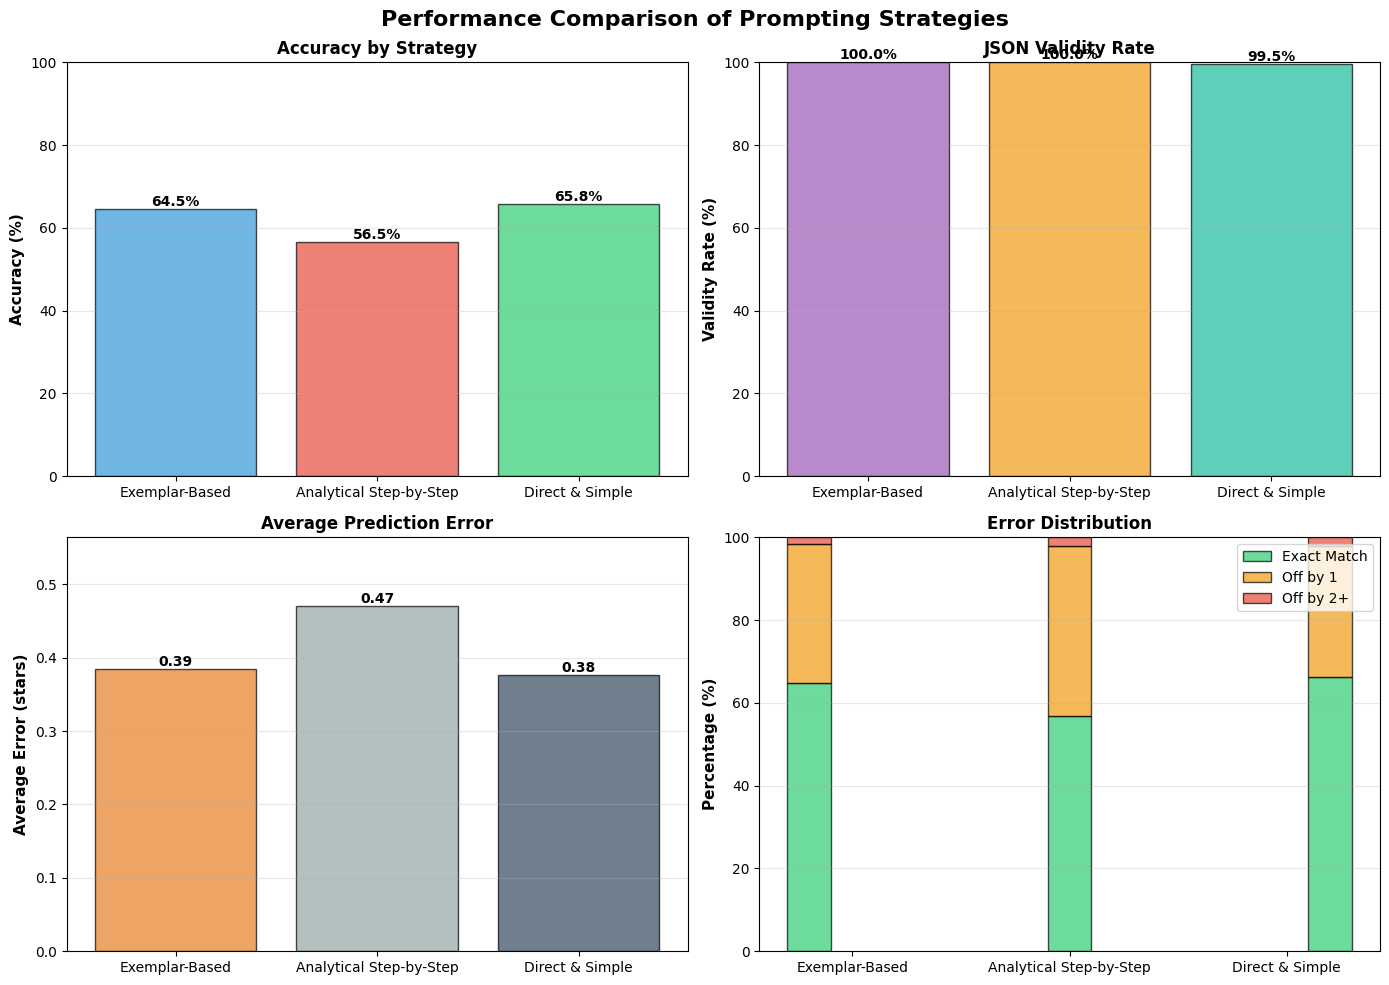

In [19]:
import matplotlib.pyplot as plt

import numpy as np

# Prepare data for visualization
strategies_names = [r['strategy'] for r in all_results]
accuracies = [r['accuracy'] for r in all_results]
validity_rates = [r['validity_rate'] for r in all_results]

# Calculate average errors
avg_errors = []
for result in all_results:
    errors = [abs(item['actual_stars'] - item['predicted_stars']) 
              for item in result['results'] if item['predicted_stars'] is not None]
    avg_errors.append(sum(errors) / len(errors) if errors else 0)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Performance Comparison of Prompting Strategies', fontsize=16, fontweight='bold')

# 1. Accuracy Comparison
ax1 = axes[0, 0]
bars1 = ax1.bar(strategies_names, accuracies, color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.7, edgecolor='black')
ax1.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
ax1.set_title('Accuracy by Strategy', fontsize=12, fontweight='bold')
ax1.set_ylim(0, 100)
ax1.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{accuracies[i]:.1f}%', ha='center', va='bottom', fontweight='bold')

# 2. Validity Rate Comparison
ax2 = axes[0, 1]
bars2 = ax2.bar(strategies_names, validity_rates, color=['#9b59b6', '#f39c12', '#1abc9c'], alpha=0.7, edgecolor='black')
ax2.set_ylabel('Validity Rate (%)', fontsize=11, fontweight='bold')
ax2.set_title('JSON Validity Rate', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 100)
ax2.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{validity_rates[i]:.1f}%', ha='center', va='bottom', fontweight='bold')

# 3. Average Error Comparison
ax3 = axes[1, 0]
bars3 = ax3.bar(strategies_names, avg_errors, color=['#e67e22', '#95a5a6', '#34495e'], alpha=0.7, edgecolor='black')
ax3.set_ylabel('Average Error (stars)', fontsize=11, fontweight='bold')
ax3.set_title('Average Prediction Error', fontsize=12, fontweight='bold')
ax3.set_ylim(0, max(avg_errors) * 1.2 if avg_errors else 1)
ax3.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars3):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{avg_errors[i]:.2f}', ha='center', va='bottom', fontweight='bold')

# 4. Error Distribution Comparison
ax4 = axes[1, 1]
x = np.arange(len(strategies_names))
width = 0.2

for i, result in enumerate(all_results):
    error_counts = {0: 0, 1: 0, 2: 0}
    for item in result["results"]:
        if item["predicted_stars"] is not None:
            error = abs(item["actual_stars"] - item["predicted_stars"])
            if error <= 2:
                error_counts[error] += 1
    
    total = sum(error_counts.values())
    percentages = [error_counts[j]/total*100 if total > 0 else 0 for j in range(3)]
    
    offset = (i - 1) * width
    ax4.bar(x[i] + offset, percentages[0], width, label='Exact Match' if i == 0 else '', 
            color='#2ecc71', alpha=0.7, edgecolor='black')
    ax4.bar(x[i] + offset, percentages[1], width, bottom=percentages[0], 
            label='Off by 1' if i == 0 else '', color='#f39c12', alpha=0.7, edgecolor='black')
    ax4.bar(x[i] + offset, percentages[2], width, bottom=percentages[0]+percentages[1], 
            label='Off by 2+' if i == 0 else '', color='#e74c3c', alpha=0.7, edgecolor='black')

ax4.set_ylabel('Percentage (%)', fontsize=11, fontweight='bold')
ax4.set_title('Error Distribution', fontsize=12, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(strategies_names)
ax4.set_ylim(0, 100)
ax4.legend(loc='upper right')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('strategy_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualization saved to: strategy_comparison.png")
plt.show()